# Autoencoders for text embeddings 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# ! pip install pytorch-pretrained-bert==0.6.2
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForTokenClassification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=False)

from IPython.display import clear_output
import re, math, time, itertools
import copy
from itertools import islice
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tnrange, tqdm_notebook

from scipy.sparse import csr_matrix
import sklearn
from sklearn import metrics
from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from fastai import *
from fastai.text import *

from torchtext import data, datasets

# sns.set_context("paper")
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
n_gpu = torch.cuda.device_count()
print(f'use_cuda: {use_cuda}, n_gpu: {n_gpu}, devices: {[torch.cuda.get_device_name(i) for i in range(n_gpu)]}')

The pre-trained model you are loading is an uncased model but you have set `do_lower_case` to False. We are setting `do_lower_case=True` for you but you may want to check this behavior.


use_cuda: True, n_gpu: 4, devices: ['Tesla K80', 'Tesla K80', 'Tesla K80', 'Tesla K80']


## Data

In [43]:
# !wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# !gunzip aclImdb_v1.tar.gz

In [7]:
# !tar -xvf aclImdb_v1.tar

In [6]:
def texts_from_folders(src, names):
    texts,labels = [],[]
    for idx,name in enumerate(names):
        path = os.path.join(src, name)
        for fname in sorted(os.listdir(path)):
            fpath = os.path.join(path, fname)
            texts.append(open(fpath).read())
            labels.append(idx)
    return texts,np.array(labels)
  
PATH='aclImdb/'
names = ['neg','pos']
X_train, y_train = texts_from_folders(f'{PATH}train',names)
X_val, y_val = texts_from_folders(f'{PATH}test',names)

In [5]:
# news_tr = fetch_20newsgroups(subset='train', shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
# news_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
# target_names = news_tr.target_names

# expr = r'[^a-zA-Z0-9!.,?]'
# parser = re.compile(expr)

# def preprocess(sent): return parser.sub(r' ', sent).lower()

# data_tr = list(map(preprocess, news_tr.data)); 
# data_test = list(map(preprocess, news_test.data)); data_tr[0]

# X_train, y_train = data_tr, news_tr.target
# X_val, X_test, y_val, y_test = train_test_split(data_test, news_test.target, test_size=0.5, random_state=42, stratify=news_test.target)
# len(X_train), len(X_val), len(X_test)

y_train мы никогда не будем использовать, X_train нужен в качестве тренировки автокодировщиков - self-supervised

In [2]:
SAMPLE_SIZES = [100, 200, 500, 1000, 2000, 5000, 10000, 24998]

def sample_data(x, y, size=100):
    size = size / len(x)
    _, x, _, y = train_test_split(x, y, test_size=size, random_state=42, stratify=y)
    return x, y 

def get_acc_on_samples(x_tr, y_train, x_v, y_val):
    accuracy_hist = []
    if type(x_tr) == scipy.sparse.csr.csr_matrix: 
        sparse = True
    else:
        sparse = False
    if sparse: x_tr = x_tr.todense()
    for size in SAMPLE_SIZES:
        x, y = sample_data(x_tr, y_train, size)
        if sparse: x = csr_matrix(x)
        svm = SGDClassifier(loss="log", max_iter=1000, tol=1e-3)
        svm.fit(x, y)
        pred = svm.predict(x_v)
        acc = sklearn.metrics.accuracy_score(y_val, pred)
        accuracy_hist.append(acc)
    return accuracy_hist
  
def plot_new_hist(hist3, label):
    hist1, hist2 = ([0.65752, 0.74968, 0.78416, 0.80984, 0.83036, 0.858, 0.86852, 0.87552],
                    [0.66448, 0.73196, 0.766, 0.79224, 0.82652, 0.85756, 0.8718, 0.88248])
    ax = plt.axes()
    plt.ylabel("Accuracy")
    plt.xlabel("# of training examples")
    plt.plot(np.array(SAMPLE_SIZES)[:, None],np.array(hist1)[:, None], label='tf-idf')
    plt.plot(np.array(SAMPLE_SIZES)[:, None],np.array(hist2)[:, None], label='bag')
    plt.plot(np.array(SAMPLE_SIZES)[:, None],np.array(hist3)[:, None], label=label)
    plt.legend()
    plt.grid()
    plt.xscale("log")
    ax.set_xlim([0,25000])
    ax.set_ylim([0.5,1])
    x = np.array(SAMPLE_SIZES)
    plt.xticks(x, SAMPLE_SIZES[:-1]+[SAMPLE_SIZES[-1]+2]) #24998 fix

## Bert tokenization

In [6]:
# sent = 'i was wondering if anyone out there could enlighten me on this car i saw the other day. it was a 2 door sports car, looked to be from the late 60s  early 70s. it was called a bricklin. the doors were really small. in addition, the front bumper was separate from the rest of the body. this is  all i know. if anyone can tellme a model name, engine specs, years of production, where this car is made, history, or whatever info you have on this funky looking car, please e mail.'
# tokenized_texts = [tokenizer.tokenize(sent)]
# print(tokenized_texts[0])

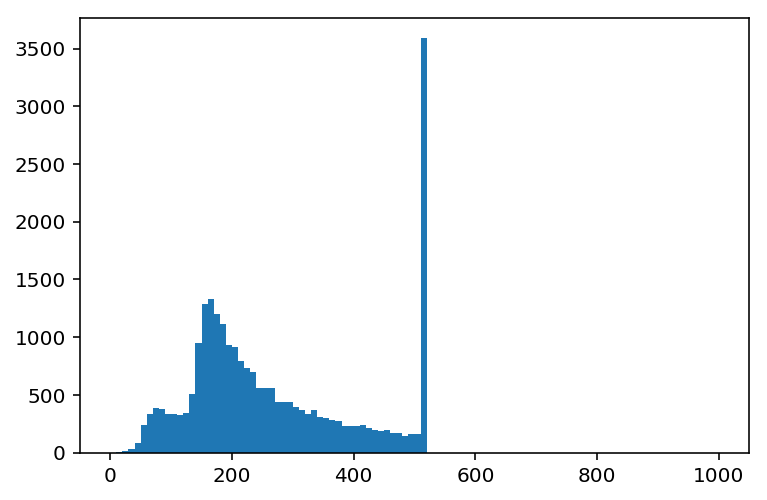

In [5]:
def tokenize_text(text):
    res = [tokenizer.tokenize(d) for d in text] 
    res = [['[CLS]'] + td[0:510] + ['[SEP]'] for td in res]
    return res
X_train_b = tokenize_text(X_train)
X_val_b = tokenize_text(X_val)
plt.hist([len(d) for d in X_train_b], bins=100, range=(0, 1000));

## Bert Contextual embeddings

In [181]:
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()
if n_gpu > 1: model = torch.nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediate): BertIntermediate(
        

In [10]:
def get_bert_word_emb(text_array):
    indexed_tokens_data = [tokenizer.convert_tokens_to_ids(td) for td in text_array]
    segments_ids_data = [[0 for _ in it] for it in indexed_tokens_data]
    tokens_tensor_data = [torch.tensor([it], device=device) for it in indexed_tokens_data]
    segments_tensors_data = [torch.tensor([si], device=device) for si in segments_ids_data]
    embs = torch.zeros([len(text_array), 512, 768], device=device)
    with torch.no_grad():
        for i in range(len(tokens_tensor_data)):
            encoded_layers, _ = model(tokens_tensor_data[i], segments_tensors_data[i])
            num_words = encoded_layers[0].shape[1]
            embs[i, :num_words, :] = encoded_layers[11][0]
            if i % 1000 == 0: 
                print(i)
                print(strftime("%Y-%m-%d %H:%M:%S", localtime()))
    return embs

In [11]:
def get_bert_doc_emb(text_array):
    indexed_tokens_data = [tokenizer.convert_tokens_to_ids(td) for td in text_array]
    segments_ids_data = [[0 for _ in it] for it in indexed_tokens_data]
    tokens_tensor_data = [torch.tensor([it]).to(device) for it in indexed_tokens_data]
    segments_tensors_data = [torch.tensor([si]).to(device) for si in segments_ids_data]
    doc_embeddings = []
    with torch.no_grad():
        for i in tnrange(len(tokens_tensor_data)):
            encoded_layers, _ = model(tokens_tensor_data[i], segments_tensors_data[i])
            doc_embeddings.append(encoded_layers[11][0, 0,:]) # get last embeding of [CLS] token
    return doc_embeddings

In [55]:
# doc_embeddings = []
# with torch.no_grad():
#     for tokens in tqdm_notebook(X_train_b):
#         t = torch.tensor(tokenizer.convert_tokens_to_ids(tokens), dtype=torch.long).to(device)
#         encoded_layers, _ = model(input_ids=t.unsqueeze_(0))
#         doc_embeddings.append(encoded_layers[11][0, 0,:])

In [7]:
# tr_tensors = [torch.tensor([tokenizer.convert_tokens_to_ids(i)]).to(device) for i in X_train_b]
# val_tensors = [torch.tensor([tokenizer.convert_tokens_to_ids(i)]).to(device) for i in X_val_b]

In [40]:
# def my_collate(batch):
#     data = [item[0] for item in batch]
#     target = [item[1] for item in batch]
#     target = torch.LongTensor(target)
#     return [data, target]

In [168]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        texts = torch.zeros(25000, 512, dtype=torch.long)
        for i, t in enumerate(x):
            t = torch.tensor(tokenizer.convert_tokens_to_ids(t), dtype=torch.long)
            texts[i, :t.size(0)] = t
        self.data = texts
        self.y = y

    def __getitem__(self, index):
        return self.data[index], self.y[index]

    def __len__(self):
        return len(self.data)

batch_size = 4
loader = DataLoader(dataset=MyDataset(X_val_b, y_val),
                        batch_size=batch_size)
# val_loader = DataLoader(dataset=MyDataset(X_val_b, y_val),
#                         batch_size=4,
#                         collate_fn=my_collate)

In [182]:
def forward(self, input_ids, token_type_ids=None, attention_mask=None, output_all_encoded_layers=True):
    input_ids = input_ids[0][input_ids[0].nonzero()].transpose(0,1)
    if attention_mask is None:
        attention_mask = torch.ones_like(input_ids)
    if token_type_ids is None:
        token_type_ids = torch.zeros_like(input_ids)

    # We create a 3D attention mask from a 2D tensor mask.
    # Sizes are [batch_size, 1, 1, to_seq_length]
    # So we can broadcast to [batch_size, num_heads, from_seq_length, to_seq_length]
    # this attention mask is more simple than the triangular masking of causal attention
    # used in OpenAI GPT, we just need to prepare the broadcast dimension here.
    extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

    # Since attention_mask is 1.0 for positions we want to attend and 0.0 for
    # masked positions, this operation will create a tensor which is 0.0 for
    # positions we want to attend and -10000.0 for masked positions.
    # Since we are adding it to the raw scores before the softmax, this is
    # effectively the same as removing these entirely.
    extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype) # fp16 compatibility
    extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

    embedding_output = self.embeddings(input_ids, token_type_ids)
    encoded_layers = self.encoder(embedding_output,
                                  extended_attention_mask,
                                  output_all_encoded_layers=output_all_encoded_layers)
    sequence_output = encoded_layers[-1]
    pooled_output = self.pooler(sequence_output)
    if not output_all_encoded_layers:
        encoded_layers = encoded_layers[-1]
    return encoded_layers[11][0, 0,:].unsqueeze_(0)

BertModel.forward = forward

In [183]:
doc_embeddings = []
with torch.no_grad():
    for data in tqdm_notebook(loader):
        inp = data[0].to(device)
        code = model(inp)
        doc_embeddings.append(code)

In [184]:
vl_doc = torch.stack(doc_embeddings)

In [185]:
vl_doc = vl_doc.reshape(25000, 768)
vl_doc = vl_doc.cpu().numpy()

In [20]:
# tr_doc   = get_bert_doc_emb(X_train_b)
# val_doc  = get_bert_doc_emb(X_val_b)

In [0]:
# tr_doc   = torch.stack(tr_doc).cpu().numpy()
# val_doc  = torch.stack(val_doc).cpu().numpy()
# test_doc = torch.stack(test_doc).cpu().numpy()

In [186]:
# np.save('data/docs_emb_bert/tr_doc.npy', tr_doc)
# np.save('data/docs_emb_bert/vl_doc.npy', vl_doc)
# np.save('data/docs_emb_bert/test_doc.npy', test_doc)

In [0]:
# tr_doc   = np.load('data/docs_emb_bert/tr_doc.npy')
# val_doc  = np.load('data/docs_emb_bert/val_doc.npy')
# test_doc = np.load('data/docs_emb_bert/test_doc.npy')

In [188]:
svm = SGDClassifier(max_iter=1000, tol=1e-3)
svm.fit(tr_doc, y_train)
pred = svm.predict(vl_doc)

print(sklearn.metrics.accuracy_score(y_val, pred))

0.86212


/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


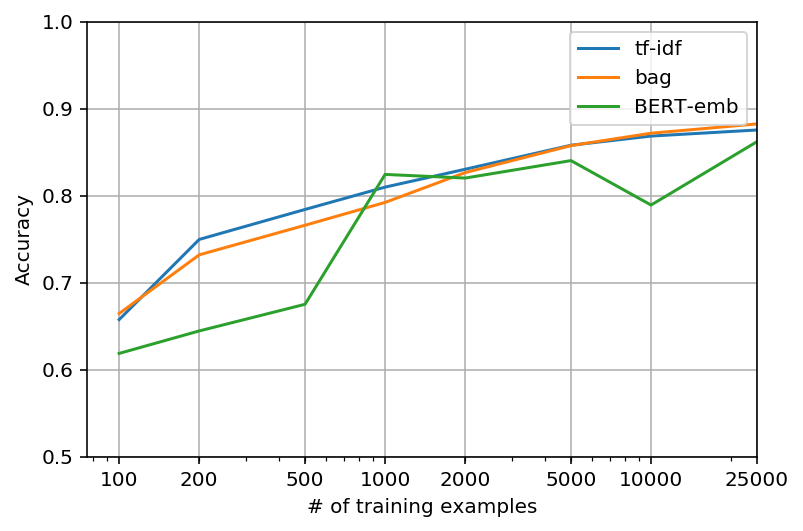

In [207]:
hist = get_acc_on_samples(tr_doc, vl_doc)
plot_new_hist(hist, 'BERT-emb')

# CountVectorizer and TfidfVectorizer

Преобразуем датасет с помощью CountVectorizer и TfidfVectorizer.

In [7]:
count_vect = CountVectorizer(tokenizer=tokenizer.tokenize, vocabulary=tokenizer.vocab)
X_train_counts = count_vect.fit_transform(X_train)
X_val_counts = count_vect.transform(X_val)

In [61]:
X_train_c = np.array([np.array(np.log10(1. + c.todense())).flatten() for c in X_train_counts])
X_val_c = np.array([np.array(np.log10(1. + c.todense())).flatten() for c in X_val_counts])

X_train_c = csr_matrix(X_train_c)
X_val_c = csr_matrix(X_val_c)

In [62]:
idf_vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize, vocabulary=tokenizer.vocab)
X_train_idf = idf_vectorizer.fit_transform(X_train)
X_val_idf = idf_vectorizer.transform(X_val)

In [214]:
svm = SGDClassifier(max_iter=1000, tol=1e-3)
svm.fit(X_train_counts, y_train)
pred = svm.predict(X_val_counts)

print(sklearn.metrics.accuracy_score(y_val, pred))

0.86536


In [215]:
svm = SGDClassifier(max_iter=1000, tol=1e-3)
svm.fit(X_train_c, y_train)
pred = svm.predict(X_val_c)

print(sklearn.metrics.accuracy_score(y_val, pred))

0.87036


In [216]:
svm = SGDClassifier(max_iter=1000, tol=1e-3)
svm.fit(X_train_idf, y_train)
pred = svm.predict(X_val_idf)

print(sklearn.metrics.accuracy_score(y_val, pred))

0.88368


In [217]:
hist1 = get_acc_on_samples(X_train_idf, X_val_idf)
hist2 = get_acc_on_samples(X_train_c, X_val_c)
hist1, hist2

([0.66316, 0.74088, 0.78824, 0.79388, 0.83624, 0.85904, 0.8688, 0.87488],
 [0.651, 0.71972, 0.75584, 0.7942, 0.82252, 0.84444, 0.86748, 0.87996])

No handles with labels found to put in legend.
/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


([<matplotlib.axis.XTick at 0x7fe6f4cdec88>,
 <a list of 8 Text xticklabel objects>)

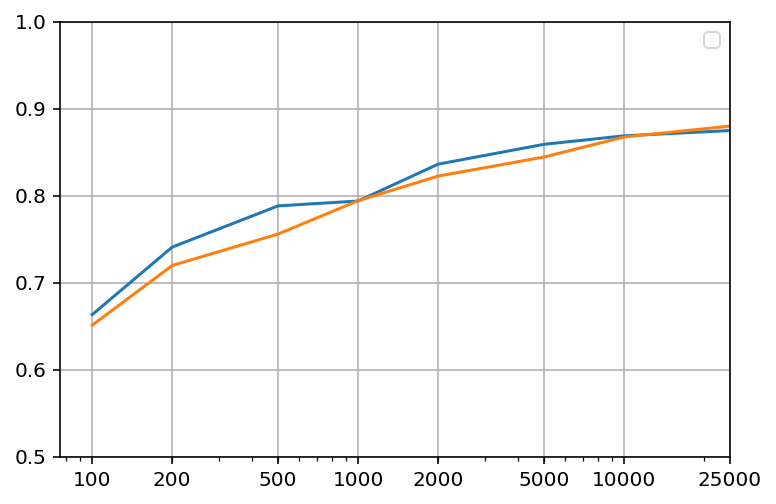

In [218]:
ax = plt.axes()
x = np.array(SAMPLE_SIZES)[:, None]
plt.plot(x, np.array(hist1)[:, None], label='')
plt.plot(x, np.array(hist2)[:, None], label='')
plt.legend()
plt.grid()
plt.xscale("log")
ax.set_xlim([0,25000])
ax.set_ylim([0.5,1])
plt.xticks(x, SAMPLE_SIZES[:-1]+[SAMPLE_SIZES[-1]+2]) #24998 fix

# Pytorch

In [10]:
def custom_loss(input, target):
    return nn.functional.binary_cross_entropy(input, target) * 1000

In [4]:
def transform_data_with_autoencoder(model, data):
    if type(data) == scipy.sparse.csr.csr_matrix: data = data.todense()
    tensor_data = torch.Tensor(data).to(device)
    codes = model.encoder(tensor_data)
    return codes.detach().cpu().numpy()

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size=256):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [0]:
class FFNN(nn.Module):
    def __init__(self, num_labels=20):
        super(FFNN, self).__init__()
        self.num_labels = num_labels
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, num_labels)

    def forward(self, x):
        x = self.dropout(x)
        x = self.classifier(x)
        return x

##  Wikitext

In [0]:
PATH = Path('data/wikitext-2')

In [0]:
def read_file(path, filename):
    docs = []
    with open(path/filename, encoding='utf8') as f:
        doc = ''
        flag=False
        for line in f:
            if line != ' \n' and line[1] != '=':
                doc += line
                flag = True
            elif flag:
                docs.append(doc)
                doc = ''
                flag = False
            
    return np.array(docs)

In [0]:
train_wiki_raw = read_file(PATH, 'wiki.train.tokens')
val_wiki_raw   = read_file(PATH, 'wiki.valid.tokens')
test_wiki_raw  = read_file(PATH, 'wiki.test.tokens')
# train_wiki_raw[0]

In [0]:
def preprocess_wiki(text):
    text = list(map(lambda x: x.lower(), text)); 
    text = list(map(lambda x: x.replace("<unk>", "UNK"), text));
    text = list(map(lambda x: x.replace("@.@", "."), text));
    text = list(map(lambda x: x.replace("@-@", "-"), text));
    text = list(map(lambda x: x.replace("@,@", ","), text));
    text = list(map(lambda x: x.replace("@-@", "-"), text));
    return text

In [0]:
train_wiki = preprocess_wiki(train_wiki_raw)
val_wiki   = preprocess_wiki(val_wiki_raw)
test_wiki  = preprocess_wiki(test_wiki_raw)
len(train_wiki), len(val_wiki), len(test_wiki)

(5515, 540, 620)

In [0]:
# print(tokenizer.tokenize(train_wiki[0]))

In [0]:
%%time
w1 = count_vect.fit_transform(train_wiki)
w2 = count_vect.transform(val_wiki)
w3 = count_vect.transform(test_wiki)

CPU times: user 32.4 s, sys: 11.8 ms, total: 32.4 s
Wall time: 32.4 s


In [0]:
%%time
X_train_w = np.array([np.array(np.log10(1. + c.todense())).flatten() for c in w1])
X_val_w   = np.array([np.array(np.log10(1. + c.todense())).flatten() for c in w2])
X_test_w  = np.array([np.array(np.log10(1. + c.todense())).flatten() for c in w3])

CPU times: user 3.65 s, sys: 961 ms, total: 4.61 s
Wall time: 4.61 s


In [0]:
X_train_w.shape, X_val_w.shape, X_test_w.shape

((5515, 30522), (540, 30522), (620, 30522))

## wiki

In [6]:
# model = Autoencoder(len(tokenizer.vocab)).to(device)

In [7]:
# t = torch.Tensor(X_train_w)
# t2 = torch.Tensor(X_val_w)
# tr_d = TensorDataset(t,t)
# val_d = TensorDataset(t2,t2)
# tr_dl = DataLoader(tr_d, bs, shuffle=True)
# val_dl = DataLoader(val_d, bs, shuffle=True)
# data = DataBunch(tr_dl, val_dl)

In [8]:
# learn = Learner(data=data, model=model, loss_func=custom_loss)
# if n_gpu > 1: learn.model = torch.nn.DataParallel(learn.model)

In [9]:
# learn.lr_find()
# learn.recorder.plot()

In [10]:
# learn.fit_one_cycle(10, slice(1e-03), wd=0.1)
# learn.save('model-pretrained')

## news20

In [30]:
model = Autoencoder(len(tokenizer.vocab)).to(device)

In [12]:
bs=32

In [36]:
X_train_c = np.array([np.array(np.log10(1. + c.todense())).flatten() for c in X_train_counts])
X_val_c = np.array([np.array(np.log10(1. + c.todense())).flatten() for c in X_val_counts])
X_train_c.shape, X_val_c.shape, type(X_train_c)

((25000, 30522), (25000, 30522), numpy.ndarray)

In [37]:
tr = np.concatenate((X_train_c, X_val_c), axis=0); 
vl = tr[48000:50000,:]
tr = tr[:48000,:]
tr.shape, vl.shape

((48000, 30522), (2000, 30522))

In [38]:
t = torch.Tensor(tr)
t2 = torch.Tensor(vl)
tr_d = TensorDataset(t,t)
val_d = TensorDataset(t2,t2)
tr_dl = DataLoader(tr_d, bs, shuffle=True)
val_dl = DataLoader(val_d, bs, shuffle=True)
data = DataBunch(tr_dl, val_dl)

In [31]:
learn = Learner(data=data, model=model, loss_func=custom_loss)
if n_gpu > 1: learn.model = torch.nn.DataParallel(learn.model)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


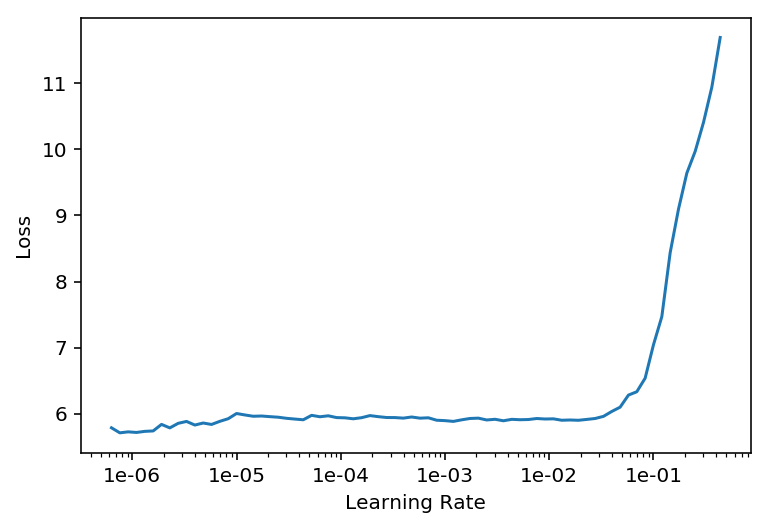

In [47]:
learn.lr_find()
learn.recorder.plot()

In [56]:
learn.fit_one_cycle(5, slice(1e-03), wd=0.1)

epoch,train_loss,valid_loss,time
0,5.677655,6.754264,01:46
1,5.729072,6.799965,01:46
2,5.827528,6.737240,01:46
3,5.638740,6.707702,01:46
4,5.478892,6.705343,01:46


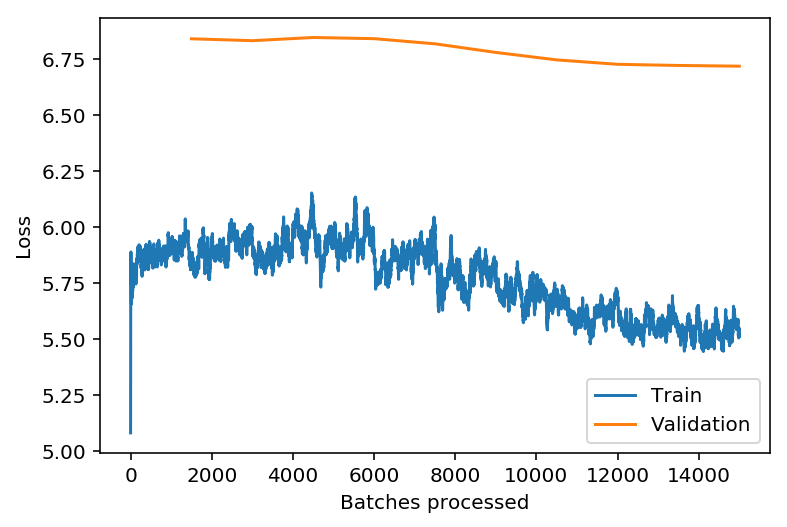

In [49]:
learn.recorder.plot_losses()

In [77]:
x_train_a = transform_data_with_autoencoder(learn.model.module, X_train_c)
x_val_a = transform_data_with_autoencoder(learn.model.module, X_val_c)

/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


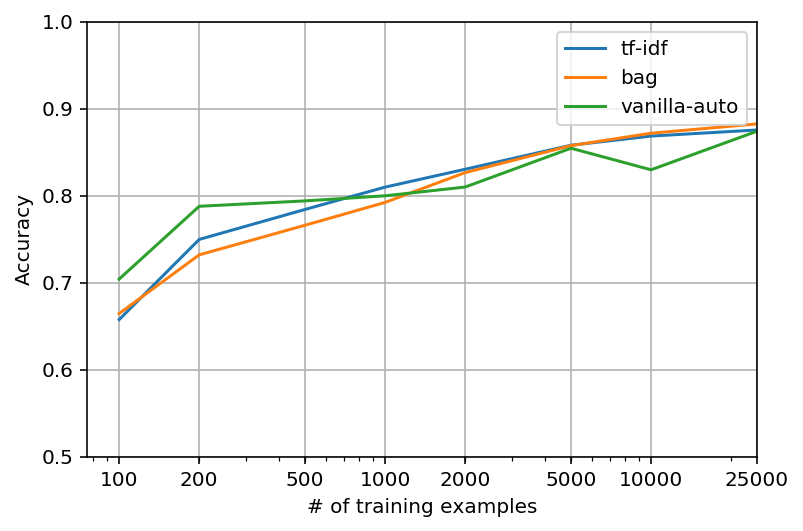

In [84]:
hist3 = get_acc_on_samples(x_train_a, x_val_a)
plot_new_hist(hist3, "vanilla-auto")

## Transformer

In [3]:
def prints(s):
    current_time = time.strftime("%Y-%m-%d-%H:%M:%S", time.gmtime())
    with open("logs.txt", "a") as text_file:
        print(f"{current_time}: {s}", file=text_file)
    print(s)
    
import copy
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
      
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)
      
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])
  
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        res = self.norm(x) # ([30, 10, 512])
        res = res[:,0].unsqueeze_(1).expand(res.size()) # ([30, 10, 512])
        return res
      
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
      
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))
      
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)
      
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)
      
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0
  
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn
  
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)
      
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)
      
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask
      
class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))
  
global max_src_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch
    if count == 1:
        max_src_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.text)+2)
    src_elements = count * max_src_in_batch
    return src_elements

def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 100 == 1:
            elapsed = time.time() - start
            s = "Epoch Step: %d Loss: %f Tokens per Sec: %f" % (i, loss / batch.ntokens, tokens / elapsed)
            start = time.time()
            prints(s)
            tokens = 0
    return total_loss / total_tokens

class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
  
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum')
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss * norm

class MultiGPULossCompute:
    "A multi-gpu loss compute and train function."
    def __init__(self, generator, criterion, devices, opt=None, chunk_size=5):
        # Send out to different gpus.
        self.generator = generator
        self.criterion = nn.parallel.replicate(criterion, 
                                               devices=devices)
        self.opt = opt
        self.devices = devices
        self.chunk_size = chunk_size
        
    def __call__(self, out, targets, normalize):
        total = 0.0
        out_scatter = nn.parallel.scatter(out, self.devices)
        generator = nn.parallel.replicate(self.generator, list(range(len(out_scatter))))
        out_grad = [[] for _ in out_scatter]
        targets = nn.parallel.scatter(targets, 
                                      target_gpus=self.devices)
        
        # Divide generating into chunks.
        chunk_size = self.chunk_size
        for i in range(0, out_scatter[0].size(1), chunk_size):
            # Predict distributions
            out_column = [[Variable(o[:, i:i+chunk_size].data, 
                                    requires_grad=self.opt is not None)] 
                           for o in out_scatter]
            
            gen = nn.parallel.parallel_apply(generator, out_column)

            # Compute loss. 
            y = [(g.contiguous().view(-1, g.size(-1)), 
                  t[:, i:i+chunk_size].contiguous().view(-1)) 
                 for g, t in zip(gen, targets)]
            loss = nn.parallel.parallel_apply(self.criterion[:len(out_scatter)], y)            
            l = nn.parallel.gather(loss, 
                                   target_device=self.devices[0])
            l = l.sum() / normalize
            total += l.data

            # Backprop loss to output of transformer
            if self.opt is not None:
                l.backward()
                for j, l in enumerate(loss):
                    out_grad[j].append(out_column[j][0].grad.data.clone())

        # Backprop all loss through transformer.            
        if self.opt is not None:
            out_grad = [Variable(torch.cat(og, dim=1)) for og in out_grad]
            o1 = out
            o2 = nn.parallel.gather(out_grad, 
                                    target_device=self.devices[0])
            o1.backward(gradient=o2)
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return total * normalize

def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys
  
def test_quality(model):
    l = sum(1 for _ in valid_iter)
    for i, batch in islice(enumerate(valid_iter), l-4, l-1):
        print("True:", end="\t")
        for i in range(1, batch.text.size(1)):
            sym = TEXT.vocab.itos[batch.text.data[0, i]]
            print(sym, end =" ")
            if sym == "[SEP]": break
        print()

        src = batch.text[:1]
        src_mask = (src != TEXT.vocab.stoi["[PAD]"]).unsqueeze(-2)
        out = greedy_decode(model, src, src_mask, 
                            max_len=256, start_symbol=TEXT.vocab.stoi["[CLS]"])
        print("Predicted:", end="\t")
        for i in range(1, out.size(1)):
            sym = TEXT.vocab.itos[out[0, i]]
            print(sym, end =" ")
            if sym == "[SEP]": break
        print()
        print("------------------------------")
        
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)
        
def plot_lengths(dataset):
    plt.hist([len(e.text) for e in dataset.examples], bins=100, range=(0, 1000))
    

In [5]:
# V = 11
# criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
# model = make_model(V, V, N=2)
# model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
#         torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

# for epoch in range(2):
#     model.train()
#     run_epoch(data_gen(V, 30, 20), model, 
#               SimpleLossCompute(model.generator, criterion, model_opt))
#     model.eval()
#     print(run_epoch(data_gen(V, 30, 5), model, 
#                     SimpleLossCompute(model.generator, criterion, None)))

22365

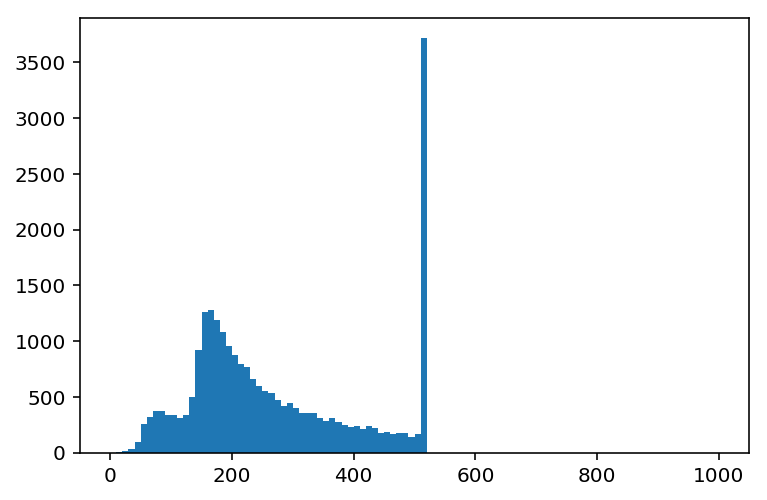

In [4]:
MAX_LEN = 512
TEXT = data.Field(tokenize=tokenizer.tokenize, 
                  batch_first=True,
                  init_token='[CLS]',
                  eos_token='[SEP]', 
                  pad_token='[PAD]',
                  unk_token='[UNK]', 
                  preprocessing=lambda x: x[0:MAX_LEN-2])
LABEL = data.Field(sequential=False)

train, val = datasets.IMDB.splits(text_field=TEXT, 
                                   label_field=LABEL)

MIN_FREQ = 3
TEXT.build_vocab(train, min_freq=MIN_FREQ)
LABEL.build_vocab(train)

plot_lengths(train)
len(TEXT.vocab) # 22365

In [13]:
orig_train_examples = copy.deepcopy(train.examples)
orig_val_examples = copy.deepcopy(val.examples)

In [9]:
def get_auto_datasets(size=512):
    tr = [ex for ex in orig_train_examples if len(ex.text) < size-1]
    vl = [ex for ex in orig_val_examples if len(ex.text) < size-1]
    exs = tr + vl
    X_tr, X_vl = train_test_split(exs, test_size=0.1, random_state=42)
    train.examples = X_tr
    val.examples = X_vl
    return train, val

(3312, 368)

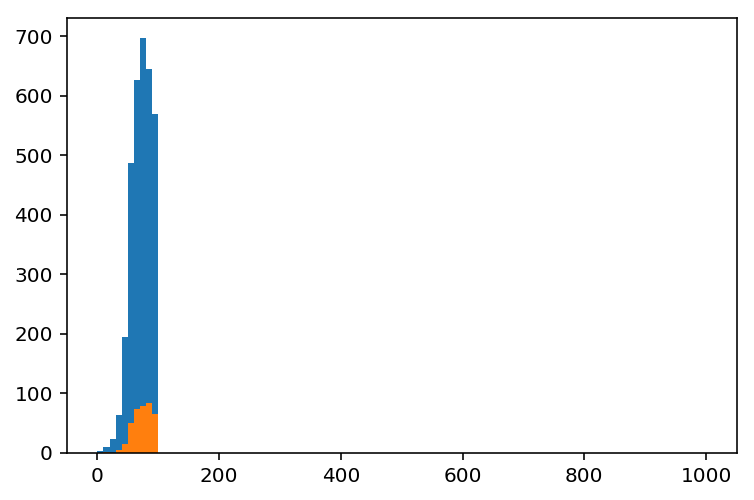

In [11]:
f_train, f_val = get_auto_datasets(100)
plot_lengths(f_train)
plot_lengths(f_val)
len(f_train), len(f_val)

In [8]:
pad_idx = TEXT.vocab.stoi["[PAD]"]

criterion = LabelSmoothing(size=len(TEXT.vocab), padding_idx=pad_idx, smoothing=0.1)
criterion.to(device)

model = torch.load('./trauto_2019-05-14-01:21:08_520.pth')
# model = make_model(len(TEXT.vocab), len(TEXT.vocab), N=6)
model.to(device)  
if n_gpu > 1: 
    model_par = nn.DataParallel(model).to(device)

model_opt = NoamOpt(model.src_embed[0].d_model, 1, 2000,
    torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [13]:
BATCH_SIZE = 10000
train_iter = MyIterator(f_train, batch_size=BATCH_SIZE, device=device,
                        repeat=False, sort_key=lambda x: (len(x.text)),
                        batch_size_fn=batch_size_fn, train=True)
valid_iter = MyIterator(f_val, batch_size=BATCH_SIZE, device=device,
                        repeat=False, sort_key=lambda x: (len(x.text)),
                        batch_size_fn=batch_size_fn, train=False)

In [5]:
tr_losses = []
vl_losses = []

In [9]:
%%time
# for i in range(100,550,20):
#     print(i)
# f_train, f_val = get_auto_datasets(515)
BATCH_SIZE = 8000
train_iter = MyIterator(train, batch_size=BATCH_SIZE, device=device,
                    repeat=False, sort_key=lambda x: (len(x.text)),
                    batch_size_fn=batch_size_fn, train=True)
valid_iter = MyIterator(val, batch_size=BATCH_SIZE, device=device,
                    repeat=False, sort_key=lambda x: (len(x.text)),
                    batch_size_fn=batch_size_fn, train=False)
for epoch in range(16):
    prints("Epoch: %s" % (epoch+1))
    model_par.train()
    loss = run_epoch((Batch(b.text, b.text, pad_idx) for b in train_iter), 
              model_par, 
              MultiGPULossCompute(model.generator, criterion, 
                                  devices=[0,1,2,3], opt=model_opt, chunk_size=514))
    tr_losses.append(loss)
    model_par.eval()
    if epoch % 5 == 0:
        with torch.no_grad():
            test_quality(model)
            loss = run_epoch((Batch(b.text, b.text, pad_idx) for b in valid_iter), 
                             model_par, 
                             MultiGPULossCompute(model.generator, criterion, 
                                devices=[0,1,2,3], opt=None, chunk_size=514))
            prints("VALIDATION LOSS: %f" % loss.item())
            vl_losses.append(loss)
                
#     if i % 100 == 0:
#         name = str(i)
#         current_time = time.strftime("%Y-%m-%d-%H:%M:%S", time.gmtime())
#         torch.save(model, "./trauto_%s_%s.pth" % (current_time, name))

Epoch: 1


/anaconda/envs/py36/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch Step: 1 Loss: 1.378235 Tokens per Sec: 1592.000000
Epoch Step: 101 Loss: 1.870785 Tokens per Sec: 6227.000000
Epoch Step: 301 Loss: 1.819553 Tokens per Sec: 6266.000000
Epoch Step: 401 Loss: 1.803898 Tokens per Sec: 6214.000000
Epoch Step: 501 Loss: 3.167712 Tokens per Sec: 6162.000000
Epoch Step: 601 Loss: 2.758060 Tokens per Sec: 6205.000000
Epoch Step: 701 Loss: 1.498593 Tokens per Sec: 6217.000000
Epoch Step: 801 Loss: 1.354508 Tokens per Sec: 6194.000000
True:	john wayne is without a doubt one of the most popular and loved actors of all time . his career stretched over forty years , and within that time he starred in films such as " angel and the bad ##man " , " the green be ##ret ##s " , " sands of i ##wo jim ##a " , " rio bravo " , " north to alaska " , and " the [UNK] " . < br / > < br / > the film ' s listed above are hailed as some of his best , unlike this 1934 effort " randy rides alone " , which has been pretty much forgotten about as time ' s gone on , which is un #

Predicted:	first , tom brown ( tom mc ##int ##ire ) is a tough , tough , tough - guy who is a loser . he is a tough guy who is a victim of a small town in the desert . he ' s a tough guy , but he ' s not a bad writer . his partner , tom ( tom mc ##int ##ire ) , is left to live with him and his partner ( robert eng ##lund ) . his sister is left in jail for the first time . when he meets the young couple , he decides to make a job of finding out that the writer and director of " the left me in trouble " . < br / > < br / > so , we get a big mistake . this is a very good example of how the film opens up with a series of flashbacks and no one left in the desert . the two meet at the end of the film , where the two cops and their daughter get a job . < br / > < br / > but that ' s not the case . this is a very med ##io ##cre film that shows the tough ##ness of the first film . it ' s not easy to tell . but it ' s just a big mistake . < br / > < br / > tom brown ( as tom sk ##er ##rit ##t ) 

Predicted:	this is a film that is so bad , it ' s hard to watch . but the only reason why ? because the film is so un ##watch ##able is the only reason for watching it . the first hour or so are the usual suspects : 1 . the second , the protagonist , a sc ##um ##onic , is a lo ##ony who would rather be in the same league as the original , and the subsequent fight scenes , which make up the entire movie . < br / > < br / > the protagonist , a young man who has been murdered by his gang , is forced to live in a small town in new york . but his own brother , who has been murdered by the gang of thugs , and his gang of thugs , and his gang of thugs , take over the entire city . this is a rather sc ##um ##my , and un ##sca ##ry piece of cinema . < br / > < br / > the film opens with a gun taking up from a gang of thugs , and the gang of thugs , and the gang of thugs , to help him . as the police come to the rescue , the cops are forced to shoot the cops , and shoot themselves into the car ,

Predicted:	john saxon is one of the greatest actors of all time , and he ' s always been a big fan of his work . however , " the night time " is a very small one , which has been the best of his films , and " the night time " , which is also one of the best of his films . < br / > < br / > as such , " the night at the time " is a pretty forget ##table look at the film . it ' s hard to believe that john savage , who was in charge of the film , was in trouble for a film that was filmed in black and white , and has a great look to it . as such , " randy " is a pretty bad film , and you ' ll be wishing that someone would put them in a studio . < br / > < br / > anyway , the rest of the cast is pretty much wasted . randy qu ##aid , whose character , " randy " , is called " randy from " the naked mile " , is just about as bad as he looks and looks like he ' s in the film . < br / > < br / > anyway , the rest of the cast are pretty much wasted . randy qu ##aid , whose character , " randy " , 

Epoch Step: 601 Loss: 3.404990 Tokens per Sec: 15835.000000
Epoch Step: 701 Loss: 3.727908 Tokens per Sec: 16009.000000
Epoch Step: 801 Loss: 3.577969 Tokens per Sec: 16308.000000
VALIDATION LOSS: 2.967480
Epoch: 12
Epoch Step: 1 Loss: 1.634545 Tokens per Sec: 7782.000000
Epoch Step: 101 Loss: 1.236310 Tokens per Sec: 6253.000000
Epoch Step: 201 Loss: 1.848471 Tokens per Sec: 6272.000000
Epoch Step: 301 Loss: 2.022540 Tokens per Sec: 6218.000000
Epoch Step: 401 Loss: 2.116828 Tokens per Sec: 6108.000000
Epoch Step: 501 Loss: 1.854738 Tokens per Sec: 6177.000000
Epoch Step: 601 Loss: 2.192439 Tokens per Sec: 6105.000000
Epoch Step: 701 Loss: 1.825527 Tokens per Sec: 6157.000000
Epoch Step: 801 Loss: 2.387137 Tokens per Sec: 6162.000000
Epoch: 13
Epoch Step: 1 Loss: 2.383227 Tokens per Sec: 7715.000000
Epoch Step: 101 Loss: 1.378927 Tokens per Sec: 6147.000000
Epoch Step: 201 Loss: 2.516225 Tokens per Sec: 6101.000000
Epoch Step: 301 Loss: 2.101686 Tokens per Sec: 6218.000000
Epoch Step:

Predicted:	this is a crime against crime against the system , but it is only the third time in the film . it is set in new york city , which is rather than the usual suspects , but it is so much fun to watch . < br / > < br / > the film has a strong protagonist , robert blake , a sc ##am , who ' s been blackmail ##ed by the gang , is killed by a gang of thugs who are sc ##um ##ming up the city for a killing sp ##ree ##ching him . the first clue is to what the heck is going on and what ' s up with him ? ? ? ? ? ? ? ? ? the lo ##vable , mean spirited , and un ##in ##formed . the two cops , make their own or re ##tar ##ded , turn into lo ##vable and lo ##vable as the one in this movie . the villains are so un ##bel ##ie ##va ##bly ugly that you almost feel sorry for them . the villains , especially the villains , are only as worthy as they seem to be in the first place . the villains , the villains , the villains , the villains , the villains , the villains , the villains , the villains ,

In [96]:
vl_losses

[tensor(7.8959, device='cuda:0'),
 tensor(6.6865, device='cuda:0'),
 tensor(4.6938, device='cuda:0'),
 tensor(4.3410, device='cuda:0'),
 tensor(4.1935, device='cuda:0'),
 tensor(4.3383, device='cuda:0'),
 tensor(4.7120, device='cuda:0'),
 tensor(3.3147, device='cuda:0'),
 tensor(3.7002, device='cuda:0'),
 tensor(4.2839, device='cuda:0'),
 tensor(2.2390, device='cuda:0'),
 tensor(2.8114, device='cuda:0'),
 tensor(3.3543, device='cuda:0')]

In [10]:
name = "520-16"
current_time = time.strftime("%Y-%m-%d-%H:%M:%S", time.gmtime())
torch.save(model, "./trauto_%s_%s.pth" % (current_time, name))
# net.load_state_dict(torch.load('./net.pth'))

/anaconda/envs/py36/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type EncoderDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/anaconda/envs/py36/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/anaconda/envs/py36/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type EncoderLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/anaconda/envs/py36/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type MultiHeadedAttention. It won't be checked for correctness upon loading.
  "type " + obj.__n

In [24]:
tr_losses,vl_losses

([tensor(8.4402, device='cuda:0'),
  tensor(8.4993, device='cuda:0'),
  tensor(8.0315, device='cuda:0'),
  tensor(7.4370, device='cuda:0'),
  tensor(6.6916, device='cuda:0'),
  tensor(6.0129, device='cuda:0'),
  tensor(5.6707, device='cuda:0'),
  tensor(5.5260, device='cuda:0'),
  tensor(5.1802, device='cuda:0'),
  tensor(4.8976, device='cuda:0'),
  tensor(4.7065, device='cuda:0'),
  tensor(4.5639, device='cuda:0'),
  tensor(4.4391, device='cuda:0'),
  tensor(4.4793, device='cuda:0'),
  tensor(4.3287, device='cuda:0'),
  tensor(4.1916, device='cuda:0'),
  tensor(4.0643, device='cuda:0'),
  tensor(3.9462, device='cuda:0'),
  tensor(3.8135, device='cuda:0'),
  tensor(4.0398, device='cuda:0'),
  tensor(3.8437, device='cuda:0'),
  tensor(3.6698, device='cuda:0'),
  tensor(3.4946, device='cuda:0'),
  tensor(3.3382, device='cuda:0'),
  tensor(3.1766, device='cuda:0'),
  tensor(3.5171, device='cuda:0'),
  tensor(3.2971, device='cuda:0'),
  tensor(3.0783, device='cuda:0'),
  tensor(2.8765, dev

# Final

In [11]:
for i, batch in islice(enumerate(valid_iter), 3, 6):
    print("True:", end="\t")
    for i in range(1, batch.text.size(1)):
        sym = TEXT.vocab.itos[batch.text.data[0, i]]
        print(sym, end =" ")
        if sym == "[SEP]": break
    print()

    src = batch.text[:1]
    src_mask = (src != TEXT.vocab.stoi["[PAD]"]).unsqueeze(-2)
    with torch.no_grad():
        out = greedy_decode(model, src, src_mask, 
                            max_len=256, start_symbol=TEXT.vocab.stoi["[CLS]"])
    print("Predicted:", end="\t")
    for i in range(1, out.size(1)):
        sym = TEXT.vocab.itos[out[0, i]]
        print(sym, end =" ")
        if sym == "[SEP]": break
    print()
    print("---------------")

True:	this is one of the worst sandra bullock movie since speed 2 but not quite that bad . i really lost it with those out of the blue not so " special effect " . guys , if you ' re an ins ##om ##nia ##c go with your girl to see this movie . i give it three sleep ##ies ! [SEP] 
Predicted:	this is one of the worst movies i ' ve ever seen . not since the very bad guys " with 2 guys that really ins ##om ##nia ##c " , but it is so camp ##y that it bog ##s down an ins ##om ##nia ##c ' s with 2 guys sitting in a pile of really hot . i give this movie 2 out of 10 . [SEP] 
---------------
True:	i think the film makes a sub ##tile reference to rouge of ki ##es ##low ##ski , as the whole atmosphere gives me a feeling of red . it seems to be that a lot of the backgrounds contain red , think of the tea - room f . e . i also think this is one of the greatest movies of the last years . [SEP] 
Predicted:	i think of the last of the film , a red haired red ##eem ##ing features of a lot of the previous 

In [ ]:
# with open('VOCAB.pkl', 'wb') as output:
#     pickle.dump(TEXT.vocab, output, pickle.HIGHEST_PROTOCOL)

with open('VOCAB.pkl', 'rb') as input:
    vocab = pickle.load(input)
    print(len(vocab)) # 22365

In [22]:
model = torch.load('./trauto_2019-05-14-01:21:08_520.pth')

In [23]:
def get_auto_hid(exs):
    x_auto = torch.zeros(25000, 512)
    y_auto = []
    model.eval()

    with torch.no_grad():
        for i, ex in enumerate(exs):
            src = torch.tensor([TEXT.vocab.stoi["[CLS]"]] + [TEXT.vocab.stoi[t] for t in ex.text] + [TEXT.vocab.stoi["[SEP]"]]).unsqueeze(-2)
            src_mask = torch.ones(src.size())
            hid = model.encode(src.to(device), src_mask.to(device))
            x_auto[i] = hid[0,0]
            y_auto.append(ex.label)
            if i % 1000 == 0: print(i)
    return x_auto, y_auto      

x_tr_auto, y_tr_auto = get_auto_hid(orig_train_examples)
x_vl_auto, y_vl_auto = get_auto_hid(orig_val_examples)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:37: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


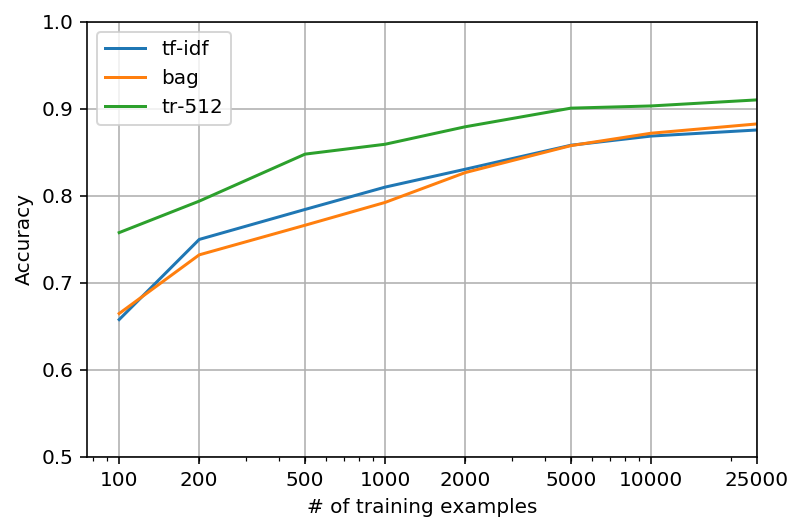

In [24]:
hist3 = get_acc_on_samples(x_tr_auto.cpu().numpy(), y_tr_auto, x_vl_auto.cpu().numpy(), y_vl_auto)
plot_new_hist(hist3, "tr-512")

In [25]:
hist3

[0.75752, 0.79372, 0.84776, 0.85912, 0.8792, 0.90064, 0.90316, 0.91012]